[*********************100%***********************]  1 of 1 completed


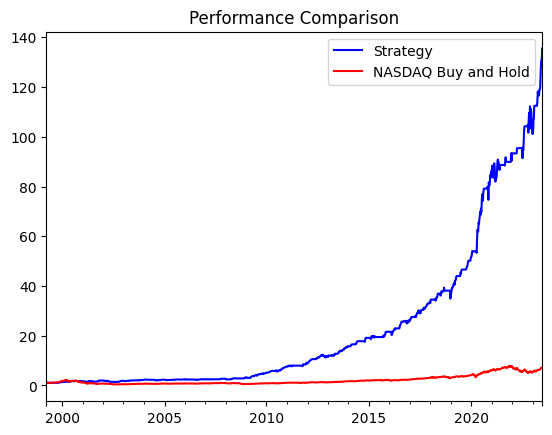

Strategy: CAGR: 22.43%, Max Drawdown: -32.92%, Sharpe Ratio: 1.26
NASDAQ Buy and Hold: CAGR: 8.45%, Max Drawdown: -82.69%, Sharpe Ratio: 0.45


In [12]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import ffn

# Read the data
nfci_data = pd.read_csv('nfci.csv')
nfci_data['date'] = pd.to_datetime(nfci_data['DATE'])
nfci_data.set_index('date', inplace=True)

# Calculate the 14-day moving average
nfci_data['nfci_sma_14'] = nfci_data['NFCI'].rolling(window=2).mean()

# Download SPY data
spy_data = yf.download('QQQ', start=nfci_data.index.min(), end=nfci_data.index.max())
spy_data = spy_data[['Close']].resample("W-FRI").last()  # we only need the adjusted close prices

# Merge the two dataframes
data = spy_data.join(nfci_data, how='inner')

# Create a signal
data['signal'] = np.where(data['NFCI'] < data['nfci_sma_14'], 1, 0)

# Calculate strategy returns
data['strategy_returns'] = data['Close'].shift(1).pct_change() * data['signal']
data['spy_returns'] = data['Close'].pct_change()

# Drop missing values
data.dropna(inplace=True)

# Plot the strategy and SPY performance
(data['strategy_returns'] + 1).cumprod().plot(label='Strategy', color='b')
(data['spy_returns'] + 1).cumprod().plot(label='NASDAQ Buy and Hold', color='r')
plt.title('Performance Comparison')
plt.legend()
plt.show()

# Annualizing factor assuming trading days
annualizing_factor = 52

# CAGR
years = (data.index[-1] - data.index[0]).days / 365.0
cagr_strategy = (1 + data['strategy_returns']).cumprod().iloc[-1] ** (1 / years) - 1
cagr_spy = (1 + data['spy_returns']).cumprod().iloc[-1] ** (1 / years) - 1

# Max Drawdown
cumulative_returns_strategy = (1 + data['strategy_returns']).cumprod()
rolling_max_strategy = cumulative_returns_strategy.expanding().max()
daily_drawdown_strategy = cumulative_returns_strategy / rolling_max_strategy - 1
max_drawdown_strategy = daily_drawdown_strategy.min()

cumulative_returns_spy = (1 + data['spy_returns']).cumprod()
rolling_max_spy = cumulative_returns_spy.expanding().max()
daily_drawdown_spy = cumulative_returns_spy / rolling_max_spy - 1
max_drawdown_spy = daily_drawdown_spy.min()

# Sharpe Ratio (assuming risk-free rate to be 0)
sharpe_ratio_strategy = np.mean(data['strategy_returns']) / np.std(data['strategy_returns']) * np.sqrt(annualizing_factor)
sharpe_ratio_spy = np.mean(data['spy_returns']) / np.std(data['spy_returns']) * np.sqrt(annualizing_factor)

# Printing the results
print(f"Strategy: CAGR: {cagr_strategy:.2%}, Max Drawdown: {max_drawdown_strategy:.2%}, Sharpe Ratio: {sharpe_ratio_strategy:.2f}")
print(f"NASDAQ Buy and Hold: CAGR: {cagr_spy:.2%}, Max Drawdown: {max_drawdown_spy:.2%}, Sharpe Ratio: {sharpe_ratio_spy:.2f}")